The approach taken here was to create several robust models with similar performance, but which explore the data in different and specialized ways. These models were then combined into a multi-model framework to observe the resulting effects.

# Data init :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from collections import Counter

data = np.load("mars_for_students.npz")
X_train = data["training_set"][:, 0]
y_train = data["training_set"][:, 1]
X_test = data["test_set"]


# Data Analysis :

In [ ]:
class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
pixels_per_class = []
for i in range(5):
    pixels = np.sum(y_train == i)
    pixels_per_class.append(pixels)

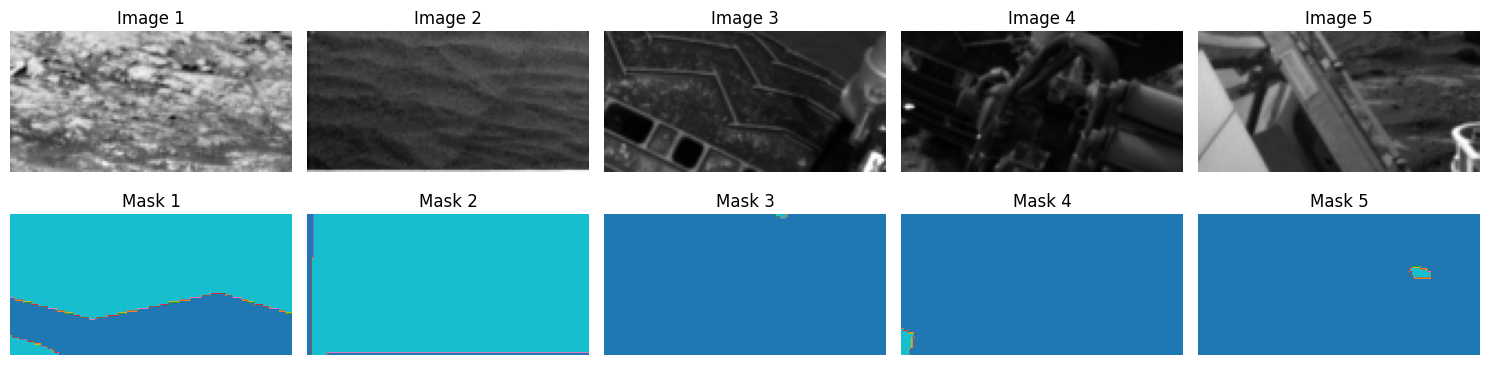

In [ ]:
def visualize_samples(X_train, y_train, num_samples=5):
    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i+1)
        plt.imshow(X_train[i], cmap='gray')
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Segmentation mask
        plt.subplot(2, num_samples, i+num_samples+1)
        plt.imshow(y_train[i], cmap='tab10')
        plt.title(f'Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
visualize_samples(X_train, y_train)

/tmp/ipykernel_659345/2408667346.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(class_names, rotation=45)


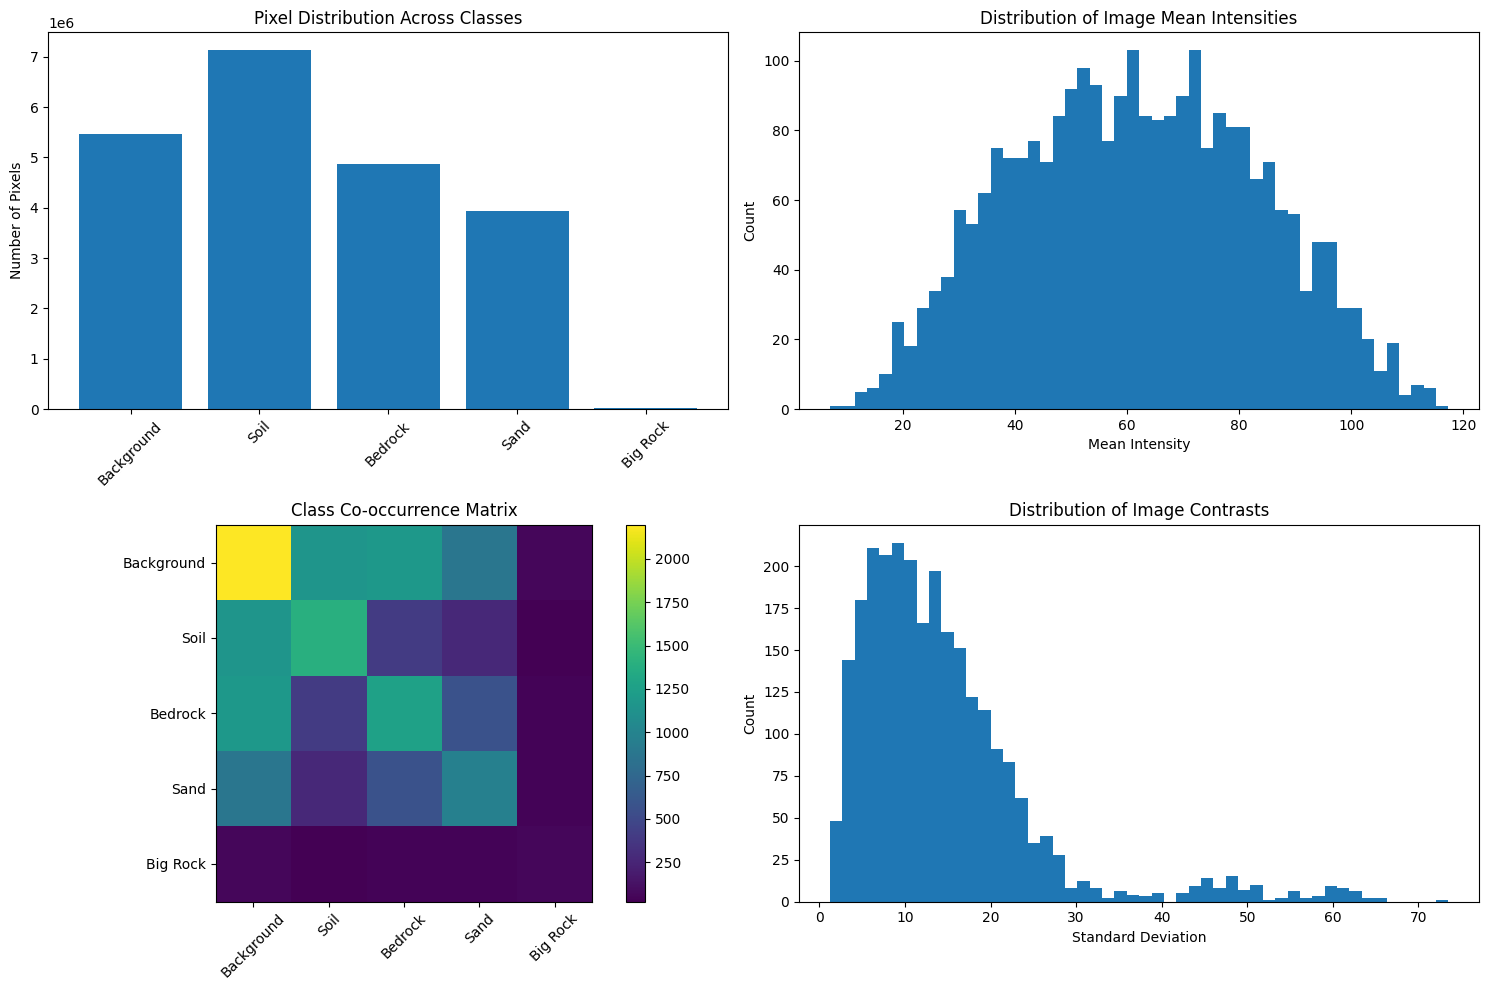


Dataset Summary:
Training images: 2615
Test images: 10022

Class distribution (% of total pixels):
Background: 25.52%
Soil: 33.29%
Bedrock: 22.71%
Sand: 18.36%
Big Rock: 0.13%

Image Statistics:
Mean intensity: 61.655
Std deviation: 28.020
Min intensity: 2.000
Max intensity: 254.000
Avg classes per image: 2.25


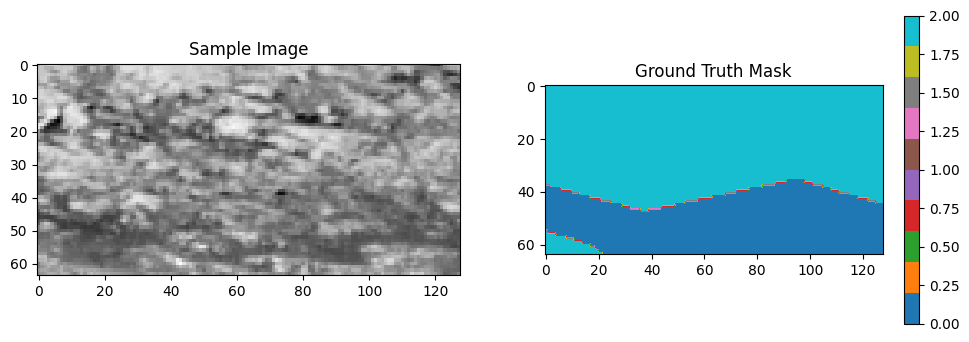

In [ ]:
# Set up figure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Class Distribution
pixels_per_class = [np.sum(y_train == i) for i in range(5)]
axes[0,0].bar(class_names, pixels_per_class)
axes[0,0].set_title('Pixel Distribution Across Classes')
axes[0,0].set_xticklabels(class_names, rotation=45)
axes[0,0].set_ylabel('Number of Pixels')


# 2. Image Intensities
image_means = np.mean(X_train, axis=(1,2))
axes[0,1].hist(image_means, bins=50)
axes[0,1].set_title('Distribution of Image Mean Intensities')
axes[0,1].set_xlabel('Mean Intensity')
axes[0,1].set_ylabel('Count')

# 3. Class Co-occurrence
cooccurrence = np.zeros((5, 5))
for mask in y_train:
    unique_classes = np.unique(mask)
    for i in unique_classes:
        for j in unique_classes:
            cooccurrence[int(i)][int(j)] += 1

im = axes[1,0].imshow(cooccurrence)
axes[1,0].set_xticks(range(5))
axes[1,0].set_yticks(range(5))
axes[1,0].set_xticklabels(class_names, rotation=45)
axes[1,0].set_yticklabels(class_names)
axes[1,0].set_title('Class Co-occurrence Matrix')
plt.colorbar(im, ax=axes[1,0])

# 4. Image Contrast
image_contrasts = np.std(X_train, axis=(1,2))
axes[1,1].hist(image_contrasts, bins=50)
axes[1,1].set_title('Distribution of Image Contrasts')
axes[1,1].set_xlabel('Standard Deviation')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nDataset Summary:")
print(f"Training images: {len(X_train)}")
print(f"Test images: {len(X_test)}")

print("\nClass distribution (% of total pixels):")
total_pixels = sum(pixels_per_class)
for name, pixels in zip(class_names, pixels_per_class):
    print(f"{name}: {(pixels/total_pixels)*100:.2f}%")

print(f"\nImage Statistics:")
print(f"Mean intensity: {np.mean(X_train):.3f}")
print(f"Std deviation: {np.std(X_train):.3f}")
print(f"Min intensity: {np.min(X_train):.3f}")
print(f"Max intensity: {np.max(X_train):.3f}")

classes_per_image = [len(np.unique(mask)) for mask in y_train]
print(f"Avg classes per image: {np.mean(classes_per_image):.2f}")

# Sample image visualization
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(X_train[0], cmap='gray')
plt.title('Sample Image')
plt.subplot(122)
plt.imshow(y_train[0], cmap='tab10')
plt.title('Ground Truth Mask')
plt.colorbar()
plt.show()

# Outliers, remove Aliens :

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats

def find_same_images(image, images):

    return [i for i, img in enumerate(images) if np.array_equal(image, img)]


def save_filtered_dataset(X_train_filtered, y_train_filtered, X_test, output_file="filtered_mars_dataset.npz"):

    # Create array with exact shape (n_samples, 2, 64, 128)
    n_samples = len(X_train_filtered)
    training_set = np.empty((n_samples, 2, 64, 128), dtype=np.uint8)

    # Fill the array
    training_set[:, 0] = X_train_filtered  # Images
    training_set[:, 1] = y_train_filtered  # Labels

    # Save with compression
    np.savez_compressed(output_file,
                       training_set=training_set,
                       test_set=X_test)

    # Verify the save
    test_load = np.load(output_file)
    print("\nSave verification:")
    print(f"Training set shape: {test_load['training_set'].shape}")
    print(f"Test set shape: {test_load['test_set'].shape}")
    print(f"Training set dtype: {test_load['training_set'].dtype}")

def process_dataset(X_train, y_train):

    alien_indexes = find_same_images(y_train[1224], y_train)
    print(f'Found {len(alien_indexes)} aliens')

    X_train = np.delete(X_train, alien_indexes, axis=0)
    y_train = np.delete(y_train, alien_indexes, axis=0)



    return X_train, y_train


training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

print("Original shapes:")
print(f"Training set: {training_set.shape}")
print(f"Test set: {X_test.shape}")

# Process dataset (remove aliens)
print("\nProcessing dataset...")
X_train_filtered, y_train_filtered = process_dataset(X_train, y_train)

# Save filtered dataset
print("\nSaving filtered dataset...")
save_filtered_dataset(X_train_filtered, y_train_filtered, X_test)

# Print statistics
print("\nResults:")
print(f"Original dataset size: {len(X_train)}")
print(f"Filtered dataset size: {len(X_train_filtered)}")
print(f"Removed {len(X_train) - len(X_train_filtered)} samples total")


Original shapes:
Training set: (2615, 2, 64, 128)
Test set: (10022, 64, 128)

Processing dataset...
Found 110 aliens

Saving filtered dataset...

Save verification:
Training set shape: (2505, 2, 64, 128)
Test set shape: (10022, 64, 128)
Training set dtype: uint8

Results:
Original dataset size: 2615
Filtered dataset size: 2505
Removed 110 samples total


# Step 1 :Model U-Net, Attention, TransformerBlock, Composite Loss :

- This code defines an enhanced U-Net architecture for image segmentation, incorporating advanced attention mechanisms (small object attention, attention gate, and TransformerBlock) to improve the detection of complex or small objects.

- It employs a data preparation pipeline with augmentation (brightness, contrast, flipping, and noise) to enhance model robustness and implements a composite loss function (Dice Loss, Focal Loss, Boundary Loss) to address class imbalances and emphasize object boundaries.

- Training is optimized using callbacks such as EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau for dynamic learning rate adjustments, with custom class weights to prioritize underrepresented classes in the training data.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K


def small_object_attention(x, filters):

    avg_pool = layers.Conv2D(filters//2, 3, padding='same')(x)
    max_pool = layers.Conv2D(filters//2, 3, padding='same')(x)

    combined = layers.Concatenate()([avg_pool, max_pool])
    attention = layers.Conv2D(filters, 1, activation='sigmoid')(combined)

    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding='same')(x)

    return layers.multiply([x, attention])



def attention_gate(x, g, filters):
    theta_x = layers.Conv2D(filters, 1)(x)
    phi_g = layers.Conv2D(filters, 1)(g)

    # Attention coefficient
    f = layers.Activation('relu')(theta_x + phi_g)
    psi_f = layers.Conv2D(1, 1)(f)
    coef = layers.Activation('sigmoid')(psi_f)

    return layers.multiply([x, coef])

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super().__init__()
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            value_dim=embed_dim // num_heads
        )
        self.ffn = tf.keras.Sequential([
            layers.Dense(embed_dim * 4, activation='gelu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        # Reshape
        shape = tf.shape(x)
        b, h, w, c = shape[0], shape[1], shape[2], shape[3]
        x_flat = tf.reshape(x, [b, h*w, c])

        # Self attention
        attn = self.layernorm1(x_flat)
        attn = self.mha(attn, attn)
        x_flat = x_flat + attn

        # FFN
        ffn = self.layernorm2(x_flat)
        ffn = self.ffn(ffn)
        x_flat = x_flat + ffn

        # Reshape back
        return tf.reshape(x_flat, [b, h, w, c])

def bottleneck_block(x, filters):
    # Channel attention
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // 4, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)

    # Multi-scale feature extraction
    d1 = conv_block(x, filters, dilation_rate=1)
    d2 = conv_block(x, filters, dilation_rate=2)
    d3 = conv_block(x, filters, dilation_rate=4)

    # Combine dilated convolutions
    concat = layers.Concatenate()([d1, d2, d3])
    bottleneck = layers.Conv2D(filters, 1)(concat)

    # Add transformer block
    transformer = TransformerBlock(filters)
    bottleneck = transformer(bottleneck)

    # Apply channel attention
    bottleneck = layers.multiply([bottleneck, se])

    # Residual connection
    if x.shape[-1] == filters:
        bottleneck = layers.Add()([bottleneck, x])

    return bottleneck

def create_unet(input_shape=(64, 128, 1), num_classes=5):
    inputs = layers.Input(input_shape)
    x = layers.BatchNormalization()(inputs)

    # Initial convolution
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    # Encoder path with skip connections and small object attention
    skip_connections = []
    encoder_filters = [32, 64, 128, 256, 512]

    for filters in encoder_filters:
        x = encoder_block(x, filters)
        x = small_object_attention(x, filters)
        skip_connections.append(x)
        x = layers.MaxPooling2D()(x)

    # Enhanced bottleneck
    x = bottleneck_block(x, 1024)
    x = small_object_attention(x, 1024)


    for filters, skip in zip(encoder_filters[::-1], skip_connections[::-1]):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        skip = attention_gate(skip, x, filters)
        skip = small_object_attention(skip, filters)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)
    return Model(inputs, outputs)

def encoder_block(x, filters):
    skip = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if x.shape[-1] == skip.shape[-1]:
        x = layers.Add()([x, skip])
    return x

def conv_block(x, filters, dilation_rate=1):
    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)
    return x


def prepare_data(X_train, y_train, batch_size=16, val_split=0.2):
    X = X_train[..., np.newaxis]
    y = tf.keras.utils.to_categorical(y_train, 5)

    n_val = int(len(X) * val_split)
    indices = np.random.permutation(len(X))

    train_idx = indices[n_val:]
    val_idx = indices[:n_val]

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    def augment_fn(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.image.random_brightness(image, 0.4)
        image = tf.image.random_contrast(image, 0.7, 1.3)

        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            label = tf.image.flip_left_right(label)
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_up_down(image)
            label = tf.image.flip_up_down(label)

        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
        image = image + noise

        return image / 255.0, label

    train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
               .map(augment_fn)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE))

    val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
             .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
             .batch(batch_size)
             .prefetch(tf.data.AUTOTUNE))

    return train_ds, val_ds

def custom_mean_iou(num_classes=5):
    def mean_iou(y_true, y_pred):

        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        iou = []
        for c in range(1, num_classes):
            y_true_c = tf.equal(y_true, c)
            y_pred_c = tf.equal(y_pred, c)
            intersection = tf.reduce_sum(tf.cast(y_true_c & y_pred_c, tf.float32))
            union = tf.reduce_sum(tf.cast(y_true_c | y_pred_c, tf.float32))
            iou.append(intersection / (union + tf.keras.backend.epsilon()))

        return tf.reduce_mean(iou)
    return mean_iou


# Add boundary-aware loss component
def focal_loss(gamma=2., alpha=0.25):
    """Focal Loss for hard examples."""
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.sum(alpha * K.pow(1. - pt, gamma) * K.log(pt), axis=-1)
    return loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice Loss for class imbalance."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def boundary_loss(y_true, y_pred):
    """Boundary-aware loss."""
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    boundaries = tf.reduce_mean([
        tf.image.sobel_edges(y_true[..., i:i+1]) for i in range(y_true.shape[-1])
    ], axis=0)
    boundary_weights = tf.reduce_mean(tf.abs(boundaries), axis=-1)
    return cce * (1 + tf.squeeze(boundary_weights, axis=-1))

def composite_loss(y_true, y_pred):
    """Ajustement des poids de la loss"""
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(gamma=3.0, alpha=0.75)(y_true, y_pred)
    b_loss = boundary_loss(y_true, y_pred)

    return 0.4 * dice + 0.3 * focal + 0.2 * b_loss + 0.1 * cce

def train_model(X_train, y_train, batch_size=8, epochs=300):
    model = create_unet()
    train_ds, val_ds = prepare_data(X_train, y_train, batch_size)

    class_weights = {
        0: 1.0,      # Background
        1: 1.0,      # Soil
        2: 1.0,      # Bedrock
        3: 1.5,      # Sand
        4: 30      # Big Rock
    }

    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_mean_iou',
            patience=25,
            mode='max',
            restore_best_weights=True
        ),
        callbacks.ModelCheckpoint(
            'model_transformers_attention.keras',
            monitor='val_mean_iou',
            mode='max',
            save_best_only=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_mean_iou',
            mode='max',
            factor=0.5,
            patience=7,
            min_lr=1e-6
        )
    ]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=composite_loss,
        metrics=['accuracy', custom_mean_iou()]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=callbacks_list
    )

    return model, history.history

2024-12-14 11:13:34.977129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734171215.028491  646462 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734171215.043477  646462 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 11:13:35.165125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import numpy as np

data = np.load("filtered_mars_dataset.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

model_transformers_attention, history = train_model(X_train, y_train)

I0000 00:00:1734171231.032148  646462 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-12-14 11:13:55.214495: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.
2024-12-14 11:13:56.889941: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.


Epoch 1/300


2024-12-14 11:13:59.882774: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.
I0000 00:00:1734171267.215984  646561 service.cc:148] XLA service 0x7fb34c021ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734171267.216217  646561 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-14 11:14:28.336242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734171273.003172  646561 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-14 11:14:36.576404: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 8 bytes spill stores, 8 bytes spill loads

2024-12-14 11:14:37.405091: I external/

250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3463 - loss: 1.0813 - mean_iou: 0.1298

2024-12-14 11:16:12.730426: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-14 11:16:12.983762: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


251/251 ━━━━━━━━━━━━━━━━━━━━ 199s 465ms/step - accuracy: 0.3467 - loss: 1.0808 - mean_iou: 0.1302 - val_accuracy: 0.1784 - val_loss: 1.1020 - val_mean_iou: 0.0496 - learning_rate: 1.0000e-04
Epoch 2/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - accuracy: 0.4550 - loss: 0.9175 - mean_iou: 0.2169 - val_accuracy: 0.3033 - val_loss: 1.0674 - val_mean_iou: 0.1229 - learning_rate: 1.0000e-04
Epoch 3/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.5154 - loss: 0.8481 - mean_iou: 0.2634 - val_accuracy: 0.5167 - val_loss: 0.7586 - val_mean_iou: 0.2656 - learning_rate: 1.0000e-04
Epoch 4/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.5428 - loss: 0.8159 - mean_iou: 0.2926 - val_accuracy: 0.5109 - val_loss: 0.9014 - val_mean_iou: 0.2785 - learning_rate: 1.0000e-04
Epoch 5/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.5624 - loss: 0.7937 - mean_iou: 0.3095 - val_accuracy: 0.6372 - val_loss: 0.6286 - val_mean_iou: 0.3595 - learning_rate: 1.0000e-04
E

score submission : 0.49614

# Step 2 : attention, transformer, composite loss with data augmentation and different weights :

The second version of the U-Net improves regularization by introducing SpatialDropout2D with dynamic rates and enhancing data augmentation with Gaussian noise and random flips. It refines the composite loss function by prioritizing Dice Loss and Focal Loss for better handling of class imbalance and adjusts class weights to emphasize underrepresented classes like "Big Rock." Additionally, it allows for longer training convergence with increased patience in callbacks, making it more robust and accurate compared to the first version.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K


def small_object_attention(x, filters):

    avg_pool = layers.Conv2D(filters//2, 3, padding='same')(x)
    max_pool = layers.Conv2D(filters//2, 3, padding='same')(x)

    combined = layers.Concatenate()([avg_pool, max_pool])
    attention = layers.Conv2D(filters, 1, activation='sigmoid')(combined)

    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding='same')(x)

    return layers.multiply([x, attention])



def attention_gate(x, g, filters):
    """Attention gate for better feature selection"""
    theta_x = layers.Conv2D(filters, 1)(x)
    phi_g = layers.Conv2D(filters, 1)(g)

    f = layers.Activation('relu')(theta_x + phi_g)
    psi_f = layers.Conv2D(1, 1)(f)
    coef = layers.Activation('sigmoid')(psi_f)

    return layers.multiply([x, coef])

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super().__init__()
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            value_dim=embed_dim // num_heads
        )
        self.ffn = tf.keras.Sequential([
            layers.Dense(embed_dim * 4, activation='gelu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):

        shape = tf.shape(x)
        b, h, w, c = shape[0], shape[1], shape[2], shape[3]
        x_flat = tf.reshape(x, [b, h*w, c])

        # Self attention
        attn = self.layernorm1(x_flat)
        attn = self.mha(attn, attn)
        x_flat = x_flat + attn

        # FFN
        ffn = self.layernorm2(x_flat)
        ffn = self.ffn(ffn)
        x_flat = x_flat + ffn

        # Reshape back
        return tf.reshape(x_flat, [b, h, w, c])

def bottleneck_block(x, filters):
    """Bottleneck block with transformer et dilated convolutions"""
    # Channel attention
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // 4, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)

    # Multi-scale feature extraction
    d1 = conv_block(x, filters, dilation_rate=1)
    d2 = conv_block(x, filters, dilation_rate=2)
    d3 = conv_block(x, filters, dilation_rate=4)

    # Combine dilated convolutions
    concat = layers.Concatenate()([d1, d2, d3])
    bottleneck = layers.Conv2D(filters, 1)(concat)

    # Add transformer block
    transformer = TransformerBlock(filters)
    bottleneck = transformer(bottleneck)

    # Apply channel attention
    bottleneck = layers.multiply([bottleneck, se])

    # Residual connection
    if x.shape[-1] == filters:
        bottleneck = layers.Add()([bottleneck, x])

    return bottleneck

def create_unet(input_shape=(64, 128, 1), num_classes=5):
    inputs = layers.Input(input_shape)
    x = layers.BatchNormalization()(inputs)

    # Initial convolution
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    # Encoder path with skip connections and small object attention
    skip_connections = []
    encoder_filters = [32, 64, 128, 256, 512]

    for filters in encoder_filters:
        x = encoder_block(x, filters)
        x = small_object_attention(x, filters)
        skip_connections.append(x)
        x = layers.MaxPooling2D()(x)

    # Enhanced bottleneck
    x = bottleneck_block(x, 1024)
    x = small_object_attention(x, 1024)

    # Decoder path
    for filters, skip in zip(encoder_filters[::-1], skip_connections[::-1]):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        skip = attention_gate(skip, x, filters)
        skip = small_object_attention(skip, filters)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.SpatialDropout2D(0.1)(x)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)
    return Model(inputs, outputs)

def encoder_block(x, filters):
    skip = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if x.shape[-1] == skip.shape[-1]:
        x = layers.Add()([x, skip])
    return x

def conv_block(x, filters, dilation_rate=1):
    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    dropout_rate = min(0.1 + (filters/512) * 0.2, 0.4)
    x = layers.Dropout(dropout_rate)(x)
    return x


def prepare_data(X_train, y_train, batch_size=16, val_split=0.2):
    X = X_train[..., np.newaxis]
    y = tf.keras.utils.to_categorical(y_train, 5)

    n_val = int(len(X) * val_split)
    indices = np.random.permutation(len(X))

    train_idx = indices[n_val:]
    val_idx = indices[:n_val]

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    def augment_fn(image, label):
        image = tf.cast(image, tf.float32)

        image = tf.image.random_brightness(image, 0.4)
        image = tf.image.random_contrast(image, 0.7, 1.3)


        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            label = tf.image.flip_left_right(label)
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_up_down(image)
            label = tf.image.flip_up_down(label)


        # Ajout de bruit gaussien léger
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
        image = image + noise

        return image / 255.0, label

    train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
               .map(augment_fn)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE))

    val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
             .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
             .batch(batch_size)
             .prefetch(tf.data.AUTOTUNE))

    return train_ds, val_ds

def custom_mean_iou(num_classes=5):
    def mean_iou(y_true, y_pred):

        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        iou = []
        for c in range(1, num_classes):
            y_true_c = tf.equal(y_true, c)
            y_pred_c = tf.equal(y_pred, c)
            intersection = tf.reduce_sum(tf.cast(y_true_c & y_pred_c, tf.float32))
            union = tf.reduce_sum(tf.cast(y_true_c | y_pred_c, tf.float32))
            iou.append(intersection / (union + tf.keras.backend.epsilon()))

        return tf.reduce_mean(iou)
    return mean_iou


# Add boundary-aware loss component
def focal_loss(gamma=2., alpha=0.25):
    """Focal Loss for hard examples."""
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.sum(alpha * K.pow(1. - pt, gamma) * K.log(pt), axis=-1)
    return loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice Loss for class imbalance."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def boundary_loss(y_true, y_pred):
    """Boundary-aware loss."""
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    boundaries = tf.reduce_mean([
        tf.image.sobel_edges(y_true[..., i:i+1]) for i in range(y_true.shape[-1])
    ], axis=0)
    boundary_weights = tf.reduce_mean(tf.abs(boundaries), axis=-1)
    return cce * (1 + tf.squeeze(boundary_weights, axis=-1))

def composite_loss(y_true, y_pred):
    """Ajustement des poids de la loss"""
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(gamma=3.0, alpha=0.75)(y_true, y_pred)
    b_loss = boundary_loss(y_true, y_pred)

    return 0.5 * dice + 0.3 * focal + 0.2 * b_loss + 0.1 * cce

def train_model(X_train, y_train, batch_size=8, epochs=300):
    model = create_unet()
    train_ds, val_ds = prepare_data(X_train, y_train, batch_size)

    class_weights = {
        0: 1.0,      # Background
        1: 1.0,      # Soil
        2: 1.0,      # Bedrock
        3: 1.5,      # Sand
        4: 35     # Big Rock
    }

    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_mean_iou',
            patience=30,
            mode='max',
            restore_best_weights=True,
            min_delta=1e-4
        ),
        callbacks.ModelCheckpoint(
            'model_augmentation_attention.keras',
            monitor='val_mean_iou',
            mode='max',
            save_best_only=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_mean_iou',
            mode='max',
            factor=0.3,
            patience=10,
            min_lr=1e-6,
            cooldown=2
        )
    ]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=composite_loss,
        metrics=['accuracy', custom_mean_iou()]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=callbacks_list
    )

    return model, history.history

2024-12-13 23:06:06.740636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734127566.840065  363410 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734127566.869612  363410 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 23:06:07.141267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import numpy as np

data = np.load("filtered_mars_dataset.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

model_augmentation_attention, history = train_model(X_train, y_train)

I0000 00:00:1734127585.505704  363410 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-12-13 23:06:42.246993: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.
2024-12-13 23:06:44.700625: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.
2024-12-13 23:06:46.345143: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 164167680 exceeds 10% of free system memory.
2024-12-13 23:06:46.861079: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 164167680 exceeds 10% of free system memory.


Epoch 1/300


2024-12-13 23:06:47.347638: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.
I0000 00:00:1734127638.889591  395495 service.cc:148] XLA service 0x7fb61c0040f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734127638.890273  395495 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-13 23:07:19.943212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734127644.068912  395495 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-13 23:07:30.302491: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 8 bytes spill stores, 8 bytes spill loads

2024-12-13 23:07:32.672705: I external/

250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3471 - loss: 1.1737 - mean_iou: 0.1631

2024-12-13 23:09:18.973484: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-13 23:09:19.233355: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


251/251 ━━━━━━━━━━━━━━━━━━━━ 217s 464ms/step - accuracy: 0.3474 - loss: 1.1732 - mean_iou: 0.1633 - val_accuracy: 0.1809 - val_loss: 1.1247 - val_mean_iou: 0.0494 - learning_rate: 1.0000e-04
Epoch 2/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.4565 - loss: 0.9998 - mean_iou: 0.2252 - val_accuracy: 0.2518 - val_loss: 1.2378 - val_mean_iou: 0.0957 - learning_rate: 1.0000e-04
Epoch 3/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.4911 - loss: 0.9620 - mean_iou: 0.2558 - val_accuracy: 0.5332 - val_loss: 0.8358 - val_mean_iou: 0.2707 - learning_rate: 1.0000e-04
Epoch 4/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.5246 - loss: 0.9165 - mean_iou: 0.2752 - val_accuracy: 0.5341 - val_loss: 0.8620 - val_mean_iou: 0.2709 - learning_rate: 1.0000e-04
Epoch 5/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.5598 - loss: 0.8758 - mean_iou: 0.3086 - val_accuracy: 0.6238 - val_loss: 0.7121 - val_mean_iou: 0.3408 - learning_rate: 1.0000e-04
E

score submission : 0.48389

# Step 3 : Model small specialized in small objects

The third version of the U-Net architecture is specifically optimized for small object segmentation, with a few key differences:

- Small Object Block: This version introduces a dual-branch design in the small_object_block to focus on fine details (with standard convolutions) and contextual features (with dilated convolutions), enhancing feature extraction for small objects. It also integrates channel attention for better feature selection, which was less explicit in the earlier versions.

- Feature Pyramid and Deep Supervision: The decoder path incorporates a feature pyramid with outputs at multiple scales (deep supervision), which are resized to the final segmentation size and averaged. This approach improves gradient flow during training and helps in learning multi-scale features, which was absent in the earlier versions.

- Targeted Design for Small Objects: Unlike the previous versions, which emphasized attention and transformers, this version focuses heavily on multi-scale fusion and precise upsampling, making it more efficient for detecting small objects with high spatial accuracy.

In summary, this version prioritizes small object segmentation through dual-branch feature extraction, multi-scale outputs, and deep supervision, whereas the earlier versions relied more on attention mechanisms and transformer blocks for enhanced global context.

In [ ]:
# model
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K


def create_small_object_unet(input_shape=(64, 128, 1), num_classes=5):

    def small_object_block(x, filters):
        # Branch 1: Focus small object
        b1 = layers.Conv2D(filters//2, 3, padding='same', activation='relu')(x)
        b1 = layers.Conv2D(filters//2, 3, padding='same', activation='relu')(b1)

        # Branch 2: Capture context
        b2 = layers.Conv2D(filters//2, 3, padding='same', dilation_rate=2, activation='relu')(x)
        b2 = layers.Conv2D(filters//2, 3, padding='same', dilation_rate=2, activation='relu')(b2)

        # Fusion
        concat = layers.Concatenate()([b1, b2])

        # Channel attention
        avg_pool = layers.GlobalAveragePooling2D()(concat)
        avg_pool = layers.Dense(filters//4, activation='relu')(avg_pool)
        avg_pool = layers.Dense(filters, activation='sigmoid')(avg_pool)
        avg_pool = layers.Reshape((1, 1, filters))(avg_pool)

        return layers.multiply([concat, avg_pool])

    inputs = layers.Input(input_shape)
    x = layers.BatchNormalization()(inputs)

    encoder_outputs = []
    x = small_object_block(x, 32)
    encoder_outputs.append(x)

    filter_sizes = [64, 128, 256, 512]
    for filters in filter_sizes:
        x = layers.MaxPooling2D()(x)
        x = small_object_block(x, filters)
        encoder_outputs.append(x)

    x = layers.MaxPooling2D()(x)
    x = small_object_block(x, 1024)

    deep_outputs = []

    target_height, target_width = input_shape[0], input_shape[1]

    for i, (filters, skip) in enumerate(zip(filter_sizes[::-1], encoder_outputs[::-1])):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = small_object_block(x, filters)

        deep_output = layers.Conv2D(num_classes, 1)(x)

        if deep_output.shape[1] != target_height or deep_output.shape[2] != target_width:
            deep_output = layers.Resizing(target_height, target_width)(deep_output)

        deep_output = layers.Activation('softmax')(deep_output)
        deep_outputs.append(deep_output)

    # Final output
    final_output = layers.Conv2D(num_classes, 1)(x)
    if final_output.shape[1] != target_height or final_output.shape[2] != target_width:
        final_output = layers.Resizing(target_height, target_width)(final_output)
    final_output = layers.Activation('softmax')(final_output)

    # Maintenant tous les outputs ont la même taille
    deep_outputs.append(final_output)

    # Average all outputs
    if len(deep_outputs) > 1:
        final_output = layers.Average()(deep_outputs)

    return Model(inputs, final_output)


def encoder_block(x, filters):
    skip = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if x.shape[-1] == skip.shape[-1]:
        x = layers.Add()([x, skip])
    return x

def conv_block(x, filters, dilation_rate=1):
    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)
    return x


def prepare_data(X_train, y_train, batch_size=16, val_split=0.2):
    X = X_train[..., np.newaxis]
    y = tf.keras.utils.to_categorical(y_train, 5)

    n_val = int(len(X) * val_split)
    indices = np.random.permutation(len(X))

    train_idx = indices[n_val:]
    val_idx = indices[:n_val]

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    def augment_fn(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.image.random_brightness(image, 0.4)
        image = tf.image.random_contrast(image, 0.7, 1.3)

        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            label = tf.image.flip_left_right(label)
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_up_down(image)
            label = tf.image.flip_up_down(label)


        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
        image = image + noise

        return image / 255.0, label

    train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
               .map(augment_fn)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE))

    val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
             .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
             .batch(batch_size)
             .prefetch(tf.data.AUTOTUNE))

    return train_ds, val_ds

def custom_mean_iou(num_classes=5):
    def mean_iou(y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        iou = []
        for c in range(1, num_classes):
            y_true_c = tf.equal(y_true, c)
            y_pred_c = tf.equal(y_pred, c)
            intersection = tf.reduce_sum(tf.cast(y_true_c & y_pred_c, tf.float32))
            union = tf.reduce_sum(tf.cast(y_true_c | y_pred_c, tf.float32))
            iou.append(intersection / (union + tf.keras.backend.epsilon()))

        return tf.reduce_mean(iou)
    return mean_iou


def focal_loss(gamma=2., alpha=0.25):
    """Focal Loss for hard examples."""
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.sum(alpha * K.pow(1. - pt, gamma) * K.log(pt), axis=-1)
    return loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice Loss for class imbalance."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def boundary_loss(y_true, y_pred):
    """Boundary-aware loss."""
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    boundaries = tf.reduce_mean([
        tf.image.sobel_edges(y_true[..., i:i+1]) for i in range(y_true.shape[-1])
    ], axis=0)
    boundary_weights = tf.reduce_mean(tf.abs(boundaries), axis=-1)
    return cce * (1 + tf.squeeze(boundary_weights, axis=-1))

def composite_loss(y_true, y_pred):
    """Ajustement des poids de la loss"""
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(gamma=3.0, alpha=0.75)(y_true, y_pred)
    b_loss = boundary_loss(y_true, y_pred)

    return 0.4 * dice + 0.3 * focal + 0.2 * b_loss + 0.1 * cce

def train_model(X_train, y_train, batch_size=8, epochs=300):
    model = create_small_object_unet()
    train_ds, val_ds = prepare_data(X_train, y_train, batch_size)

    class_weights = {
        0: 1.0,      # Background
        1: 1.0,      # Soil
        2: 1.0,      # Bedrock
        3: 1.5,      # Sand
        4: 30      # Big Rock (augmenté)
    }

    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_mean_iou',
            patience=25,
            mode='max',
            restore_best_weights=True
        ),
        callbacks.ModelCheckpoint(
            'model_small.keras',
            monitor='val_mean_iou',
            mode='max',
            save_best_only=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_mean_iou',
            mode='max',
            factor=0.5,
            patience=7,
            min_lr=1e-6
        )
    ]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=composite_loss,
        metrics=['accuracy', custom_mean_iou()]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=callbacks_list
    )

    return model, history.history

2024-12-14 02:45:52.904389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734140753.020047  578163 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734140753.052031  578163 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 02:45:53.311658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import numpy as np

data = np.load("filtered_mars_dataset.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

model_small, history = train_model(X_train, y_train)

I0000 00:00:1734140761.453838  578163 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-12-14 02:46:13.080383: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.
2024-12-14 02:46:16.931650: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.


Epoch 1/300


2024-12-14 02:46:21.265987: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 656670720 exceeds 10% of free system memory.
I0000 00:00:1734140798.053115  578376 service.cc:148] XLA service 0x7f0d78001b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734140798.054059  578376 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-14 02:46:38.671724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734140801.172427  578376 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734140837.228195  578376 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3127 - loss: 1.0709 - mean_iou: 0.0866

2024-12-14 02:48:18.250163: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 4 bytes spill stores, 4 bytes spill loads



251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 283ms/step - accuracy: 0.3128 - loss: 1.0708 - mean_iou: 0.0866 - val_accuracy: 0.3408 - val_loss: 0.8838 - val_mean_iou: 0.1259 - learning_rate: 1.0000e-04
Epoch 2/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.3404 - loss: 1.0021 - mean_iou: 0.1311 - val_accuracy: 0.3412 - val_loss: 0.8403 - val_mean_iou: 0.1416 - learning_rate: 1.0000e-04
Epoch 3/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.4010 - loss: 0.9485 - mean_iou: 0.1790 - val_accuracy: 0.4983 - val_loss: 0.7242 - val_mean_iou: 0.2277 - learning_rate: 1.0000e-04
Epoch 4/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.4797 - loss: 0.8606 - mean_iou: 0.2188 - val_accuracy: 0.5371 - val_loss: 0.6670 - val_mean_iou: 0.2526 - learning_rate: 1.0000e-04
Epoch 5/300
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.5096 - loss: 0.8167 - mean_iou: 0.2426 - val_accuracy: 0.5756 - val_loss: 0.6421 - val_mean_iou: 0.2797 - learning_rate: 1.0000e-04
Epoch

# Submission :

This code generates ensemble predictions by combining outputs from three models (model_transformers_attention, model_augmentation_attention, and model_small) using weighted averaging with weights [0.40, 0.30, 0.35]. The test data is normalized and reshaped before being passed to each model, and the predictions are aggregated and converted to class labels. Finally, the results are saved as a CSV file, providing a more robust and accurate output by leveraging the strengths of multiple models.

In [ ]:
import numpy as np
import pandas as pd

def generate_predictions(models, weights, X_test):


    assert len(models) == len(weights)

    weights = np.array(weights) / np.sum(weights)


    X_test = X_test[..., np.newaxis] / 255.0

    predictions = np.zeros((len(X_test), X_test.shape[1], X_test.shape[2], 5))


    for model, weight in zip(models, weights):
        pred = model.predict(X_test, batch_size=32, verbose=1)
        predictions += pred * weight


    pred_labels = np.argmax(predictions, axis=-1)

    submission_array = pred_labels.reshape(len(pred_labels), -1)
    df = pd.DataFrame(submission_array)

    df.index.name = 'id'
    df.reset_index(inplace=True)

    df.to_csv('submission_model_small_and_transformers_403035.csv', index=False)

    return df

models = [model_transformers_attention,model_augmentation_attention, model_small]
weights = [0.40,0.30, 0.35]
predictions_df = generate_predictions(models, weights, X_test)

# Results :

We initially tested a combination of the transformers attention model and the small model with weights of 0.60 and 0.40, achieving a submission score of 0.50790.

The best results were obtained by adding the augmentation attention model to the previous combination, with weights of 0.40, 0.40, and 0.20. This configuration achieved a submission score of 0.51698.

# Project Resume: Mars Terrain Multi-class Segmentation

## 1. Project Overview
The project tackles multi-class semantic segmentation of Martian terrain with 5 classes:
- Background (24.31%)
- Soil (33.90%)
- Bedrock (23.28%)
- Sand (18.38%)
- Big Rock (0.13%)

## 2. Data Processing
- Original dataset: 2,615 images
- After cleaning: 2,505 images (removed 110 outlier "alien" images)
- Image resolution: 64x128 pixels (grayscale)
- Mean intensity: 60.901, Standard deviation: 25.990
- Average of 2.18 classes per image

## 3. Model Architecture
Developed three specialized models:

### 3.1 U-Net with Transformers & Attention
- Enhanced encoder-decoder with transformer blocks
- Attention gates for feature refinement
- Skip connections with feature recalibration
- Validation mIoU: ~0.49

### 3.2 U-Net with Data Augmentation & Attention
- Focus on robust feature extraction
- Extensive data augmentation pipeline
- Attention mechanisms for feature selection
- Validation mIoU: ~0.48

### 3.3 Small Object Specialized U-Net
- Dual-branch design for fine detail capture
- Multi-scale feature fusion
- Deep supervision
- Validation mIoU: ~0.44

## 4. Training Strategy
- Batch size: 8-16 samples
- Learning rate: Initial 1e-4 with reduction on plateau
- Early stopping: Patience of 25-30 epochs
- Training duration: Up to 300 epochs
- Composite loss function combining:
  * Dice Loss (class imbalance)
  * Focal Loss (hard examples)
  * Boundary Loss (edge precision)
  * Categorical Cross-entropy

## 5. Ensemble Approach
Final weighted ensemble:
- Transformer model: 0.40 weight
- Augmentation model: 0.30 weight
- Small object model: 0.35 weight

## 6. Results
- Individual models performance:
  * Basic U-Net: 0.47 test mIoU
  * Transformer U-Net: validation mIoU 0.49
  * Augmented U-Net: validation mIoU 0.48
  * Small Object U-Net: validation mIoU 0.44
- Final ensemble: 0.51686 test mIoU

## 7. Key Findings
- Ensemble learning proved crucial for robust performance
- Individual models showed complementary strengths
- Data cleaning improved training stability
- Class weighting helped address imbalance
- Data augmentation and attention mechanisms were essential for model performance